# Tree Clustering Code 

* Code is based on this implementation of decision tree: https://machinelearningmastery.com/implement-decision-tree-algorithm-scratch-python/
* This code builds decision tree using tree distances 
* Data Requirements:
    - numerical 
    - the first column must be the label

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_fscore_support
import time
import random

## Tree Cluster Algorithm

In [4]:
# read data and distances
train_final_dist = pd.read_csv("train_final_dist.csv")
test_final_dist = pd.read_csv("test_final_dist.csv")
full_data_train = pd.read_csv("full_data_train.csv")
full_data_test = pd.read_csv("full_data_test.csv")
train_final_dist = train_final_dist[['i1', 'i2', 'tree_dist']]
test_final_dist = test_final_dist[["i1", "i2", "tree_dist"]]
df_train = full_data_train[["Survived", "Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Deck"]]
df_test = full_data_test[["Survived", "Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Deck"]]
dataset_train = df_train.to_numpy()
dataset_test = df_test.to_numpy()

In [5]:
subset = train_final_dist[['i1', 'i2']]
tuples = [tuple(x) for x in subset.to_numpy()]

In [6]:
#tuples[-1]
# lst = [1, 2]
# {1 -> set((1, 2), (1, 3), (1, 4)) and 2->set((2, 3), (2, 4)) and 3->set((3, 4)}
# loop through list and take set intersection each time 

In [7]:
ind_tup_dct = {}
for i, j in tuples:
    if i in ind_tup_dct.keys():
        ind_tup_dct[i].add((i, j))
        
    else:
        ind_tup_dct[i] = set()
        ind_tup_dct[i].add((i, j))
    if j in ind_tup_dct.keys():
        ind_tup_dct[j].add((i, j))
    else:
        ind_tup_dct[j] = set()
        ind_tup_dct[j].add((i, j))

In [6]:
dists = train_final_dist['tree_dist']

In [7]:
subset = train_final_dist[['i1', 'i2']]
tuples = [tuple(x) for x in subset.to_numpy()]
train_final_dist_dct = dict(zip(tuples, train_final_dist['tree_dist'])) 

In [12]:
# use 
# heap - binary tree that's sorted ==> n leaves, log n levels (find in order log n time)
# hash table - constant time, uses extra memory to find value to fast
# dictioary or set = hashtable w/out values 
# sorted list - 
# think about complexity to take elements out or find elements - use hash !!! 
# if dict in node (keys) of blahs - 
# more than one dictionary - left node to right node, distance 
# dictioary: right ndoe to left node, distance
# which leaf node in - find rep of every 
# leaf tuple -> a node in leaf tuple, number of leaves in leaf tuple 
# find leaf tuple in dictionary 
# add leaf tuple to dictonary, rep node for leaf tuple 
# passing through list of all no
# num nodes x however long it takes leaf 
# DON'T USE DATAFRAMES 

In [13]:
# Split a dataset based on an attribute and an attribute value
def test_split(index, value, dataset, df):
    feature = df.columns[index]
    left, right = list(), list()
    indleft, indright = list(), list()
    left_df = df[df[feature] < value]
    right_df = df[df[feature] >= value]
    for i, row in enumerate(dataset):
        if row[index] < value:
            left.append(row)
            indleft.append(i)
        else:
            right.append(row)
            indright.append(i)
    #print(indleft)
    return left, right, indleft, indright, left_df, right_df
 
# Calculate the avg distance for a split dataset
def distance_index(indleft, indright, train_final_dist):
    left_len = len(indleft)
    right_len = len(indright)
    mean_left_dist = 0
    mean_right_dist = 0
    if left_len > 0:
        resultL = ind_tup_dct[indleft[0]]
        for i in indleft[:-1]:
            resultL = resultL.intersection(ind_tup_dct[i])
        for k in resultL:
            mean_left_dist += train_final_dist_dct[k]
    if right_len > 0:
        resultR = ind_tup_dct[indright[0]]
        for j in indright[:-1]:
            resultR = resultR.intersection(ind_tup_dct[j])
        for l in resultR:
            mean_right_dist += train_final_dist_dct[l]

    
    left_avg = (mean_left_dist / left_len) * (left_len / (left_len + right_len)) if left_len > 0 else 0
    right_avg = (mean_right_dist / right_len) * (right_len / (left_len + right_len)) if right_len > 0 else 0
    
    return left_avg + right_avg

# Select the best split point for a dataset
def get_split(dataset, df):
    #class_values = list(set(row[0] for row in dataset))
    b_index, b_value, b_score, b_groups = 99999, 99999, 99999, None
    #print(len(dataset[0])*len(dataset))
    # sample random rows...
    for index in range(1, len(dataset[0])):
        for row in dataset:
            left, right, indleft, indright, left_df, right_df = test_split(index, row[index], dataset, df)
            groups = left, right, left_df, right_df
            dist = distance_index(indleft, indright, train_final_dist)
            if dist < b_score:
                b_index, b_value, b_score, b_groups = index, row[index], dist, groups
    return {'index':b_index, 'value':b_value, 'groups':b_groups}

In [14]:
# Create a terminal node value
def to_terminal(group):
    outcomes = [row[0] for row in group]
    return max(set(outcomes), key=outcomes.count)
 
# Create child splits for a node or make terminal
def split(node, max_depth, min_size, depth):
    #print(node)
    left, right, left_df, right_df = node['groups']
    del(node['groups'])
    # check for a no split
    if not left or not right:
        #print('here')
        node['left'] = node['right'] = to_terminal(left + right)
        return
    # check for max depth
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    # process left child
    if len(left) <= min_size:
        #print('here')
        node['left'] = to_terminal(left)
    else:
        #print('here')
        node['left'] = get_split(left, left_df)
        split(node['left'], max_depth, min_size, depth+1)
    # process right child
    if len(right) <= min_size:
        #print('here')
        node['right'] = to_terminal(right)
    else:
        #print('here')
        node['right'] = get_split(right, right_df)
        split(node['right'], max_depth, min_size, depth+1)

In [15]:

# Build a decision tree
def build_tree(train, df, max_depth, min_size=30):
    root = get_split(train, df)
    #print('here')
    split(root, max_depth, min_size, 1)
    return root
 
# Print a decision tree
def print_tree(node, df, depth=0):
    if isinstance(node, dict):
        print('%s[%s < %.3f]' % ((depth*' ', (df.columns[node['index']]), node['value'])))
        print_tree(node['left'], df, depth+1)
        print_tree(node['right'], df, depth+1)
    else:
        print('%s[%s]' % ((depth*' ', node)))

In [16]:
def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']

# Experimenting with Time

In [17]:
start = time.time()
tree_full = build_tree(dataset_train, df_train, 20)
end = time.time()
print(end - start)

17.70847201347351


## Decision Tree Cluster 

In [18]:
y_pred_dt = []
for row in dataset_test:
    y_pred_dt.append(predict(tree_full, row))

In [20]:
conf_mat = confusion_matrix(df_test["Survived"], y_pred_dt)
print(conf_mat)

[[124  50]
 [ 29  65]]


In [21]:
import sklearn

In [23]:
print(sklearn.metrics.roc_auc_score(df_test["Survived"],y_pred_dt))

0.7020665199315236


## Decision Tree - Supervised Baseline Comparison

In [24]:
clf = DecisionTreeClassifier(max_depth=5, min_samples_split= 30, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

NameError: name 'X_train' is not defined

In [25]:
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

NameError: name 'y_test' is not defined

In [66]:
# weighted precision, recall, f-score, support 
clf = DecisionTreeClassifier(max_depth=5, min_samples_split= 30, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(sklearn.metrics.roc_auc_score(y_test,y_pred))

0.772315969674737


## Plots

In [16]:
depth_lst = []
score_clust = []
score_baseline= []
for i in range(1, 21):
    print(i)
    depth_lst.append(i)
    tree_clust = build_tree(dataset_train, df_train, i, 30)
    y_pred_dt = []
    for row in dataset_test:
        y_pred_dt.append(predict(tree_clust, row))
    score_clust.append(sklearn.metrics.roc_auc_score(y_test,y_pred_dt))
    
    clf = DecisionTreeClassifier(max_depth=i, min_samples_split= 30, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score_baseline.append(sklearn.metrics.roc_auc_score(y_test,y_pred))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


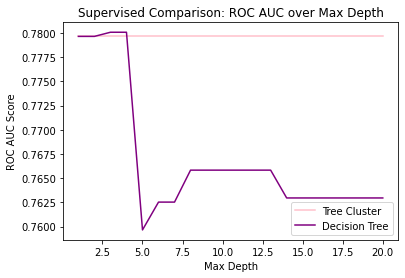

In [17]:
plt.plot(depth_lst, score_clust, color='pink', label="Tree Cluster")
plt.plot(depth_lst, score_baseline, color='purple', label="Decision Tree")
plt.xlabel("Max Depth")
plt.ylabel("ROC AUC Score")
plt.title("Supervised Comparison: ROC AUC over Max Depth")
plt.legend()
plt.show()

In [ ]:
# keep track of which nodes each example matches with 
# GOAL: in tree cluster, given list we want to output average distance between all nodes in list 
# convert to list of nodes + get distances between each node 

In [1]:
for i in range(1000000):
    1 + 2
    

In [8]:
ind_tup_dct[0]

{(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (0, 10),
 (0, 11),
 (0, 12),
 (0, 13),
 (0, 14),
 (0, 15),
 (0, 16),
 (0, 17),
 (0, 18),
 (0, 19),
 (0, 20),
 (0, 21),
 (0, 22),
 (0, 23),
 (0, 24),
 (0, 25),
 (0, 26),
 (0, 27),
 (0, 28),
 (0, 29),
 (0, 30),
 (0, 31),
 (0, 32),
 (0, 33),
 (0, 34),
 (0, 35),
 (0, 36),
 (0, 37),
 (0, 38),
 (0, 39),
 (0, 40),
 (0, 41),
 (0, 42),
 (0, 43),
 (0, 44),
 (0, 45),
 (0, 46),
 (0, 47),
 (0, 48),
 (0, 49),
 (0, 50),
 (0, 51),
 (0, 52),
 (0, 53),
 (0, 54),
 (0, 55),
 (0, 56),
 (0, 57),
 (0, 58),
 (0, 59),
 (0, 60),
 (0, 61),
 (0, 62),
 (0, 63),
 (0, 64),
 (0, 65),
 (0, 66),
 (0, 67),
 (0, 68),
 (0, 69),
 (0, 70),
 (0, 71),
 (0, 72),
 (0, 73),
 (0, 74),
 (0, 75),
 (0, 76),
 (0, 77),
 (0, 78),
 (0, 79),
 (0, 80),
 (0, 81),
 (0, 82),
 (0, 83),
 (0, 84),
 (0, 85),
 (0, 86),
 (0, 87),
 (0, 88),
 (0, 89),
 (0, 90),
 (0, 91),
 (0, 92),
 (0, 93),
 (0, 94),
 (0, 95),
 (0, 96),
 (0, 97),
 (0, 98),
 (0, 99),
 (0, 100),
 (0, 101

In [ ]:
# given list of reps, find distance between all of them
# take set and get distances from each pair of distances to each other

# weight the sum of those pairs based on how many of each i think ?

# example: left_inds [10, 9, 8, 7, 6, 5] => with rep nodes [2, 2, 3, 3, 1, 3] => set(1, 2, 3) 
# pairs: {10->9, 10->8, 10->7, 10->6, 10->5, 9->8, 9->7, 9->6, 9->5, 8->7, 8->6, 8->5, 7->6, 6->5}
# remove with dist of 0: {10->8, 10->7, 10->6, 10->5, 9->8, 9->7, 9->6, 9->5, 8->6, 7->6, 7->5, 6->5}
# => distance pairs based on output of train final dist [(1, 2): 1, (1, 3): 5, (2, 3): 10]
# => count each: {1: 1, 2:2, 3:3}
# (1, 2) => 1*2, (1, 3)=> 1*3, (2, 3) => 

In [10]:
train_comb = []
lst = [10, 9, 8, 7, 6, 5]
for i in range(len(lst)):
    for j in range(i+1, len(lst)):
        train_comb.append((lst[i], lst[j]))
train_comb

[(10, 9),
 (10, 8),
 (10, 7),
 (10, 6),
 (10, 5),
 (9, 8),
 (9, 7),
 (9, 6),
 (9, 5),
 (8, 7),
 (8, 6),
 (8, 5),
 (7, 6),
 (7, 5),
 (6, 5)]

In [11]:
for i in range(40):
    for j in range(40):
        1 + 2

In [ ]:
# loop through the list of nodes to translate them into rep nodes
# count number of times each rep node appears 
# get a list of pairs of rep nodes  
# go through list of pairs, get count of each pair and multiply them together, multiply them to distance
# accumulate for each pair, divide by len of ind list 